# Goal Conditioned Value function

In [172]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import imageio
from IPython.display import Video, display
import json
import os
from tqdm import tqdm

from src.jepa2 import JEPA
from src.data.dataset import PointMazeSequences
from envs.pointmaze import PointMazeEnv


os.environ["MUJOCO_GL"] = "egl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preamble

### Model

We begin by loading the checkpoint of the trained model



In [173]:
path = "checkpoints/jepa/last-v46.ckpt"
model = JEPA.load_from_checkpoint(path)
model.eval();

### Environment

We then proceed by loading the possible layouts and creating a PointMaze environment

In [174]:
with open('data/train_layouts.json', "r") as f:
    maze_maps = json.load(f)["maps"]

map_idx = 2
maze_map = maze_maps[map_idx]

In [175]:
side = max(len(maze_map), len(maze_map[0])) + 2
env = PointMazeEnv(
    maze_map=maze_map,
    render_goal=False,
    render_img_size=(64, 64),
    camera_distance=side
)
env.reset();

Choose initial and goal position

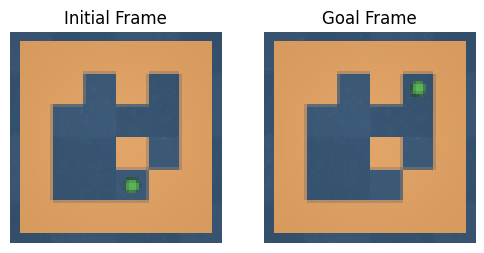

In [208]:
goal_position = np.array([-1.5, -1.5]) 
goal_state = np.array([goal_position[0], goal_position[1], 0.0, 0.0])
env.set_position(goal_position);
goal_frame = env.render()

# initial_position = np.array([1.5, 1.5])
initial_position = np.array([1.5, -.5])
initial_state = np.array([initial_position[0], initial_position[1], 0.0, 0.0])
env.set_position(initial_position);    
initial_frame = env.render()

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(initial_frame)
axs[0].set_title("Initial Frame")
axs[0].axis('off')
axs[1].imshow(goal_frame)
axs[1].set_title("Goal Frame")
axs[1].axis('off')
plt.show()

## Reconstruction

In [209]:
# with torch.no_grad():
#     initial_state = torch.tensor(initial_state, device=device).unsqueeze(0).float()
#     goal_state = torch.tensor(goal_state, device=device).unsqueeze(0).float()

#     z_goal_frame = model.visual_encoder(
#         torch.from_numpy(goal_frame.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
#     ).squeeze(0).cpu().numpy()
#     recon_goal_frame = model.visual_decoder(
#         torch.from_numpy(z_goal_frame).unsqueeze(0).float().to(device)
#     ).squeeze(0).permute(1, 2, 0).cpu().numpy() * 255.0

# fig, axs = plt.subplots(1, 2, figsize=(6, 3))
# axs[0].imshow(goal_frame)
# axs[0].set_title("Original Goal Frame")
# axs[0].axis('off')
# axs[1].imshow(recon_goal_frame.astype(np.uint8))
# axs[1].set_title("Reconstructed Goal Frame")
# axs[1].axis('off')
# plt.show()

## Value Function

Sample inside the walkable part

In [210]:
def rotate90_and_hflip(coords):
    return np.column_stack([-coords[:, 1], -coords[:, 0]])

In [211]:
centers = np.array(env.maze.unique_reset_locations)
samples = []
for center in centers:
    # Create grid
    x_min, x_max = center[0] - 0.48, center[0] + 0.48
    y_min, y_max = center[1] - 0.48, center[1] + 0.48
    # x_min, x_max = center[0] - 1.48, center[0] + 1.48
    # y_min, y_max = center[1] - 1.48, center[1] + 1.48
    resolution = 25
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    samples.append(grid_points)
samples = np.vstack(samples)

centers_rotated = rotate90_and_hflip(centers)
samples_rotated = rotate90_and_hflip(samples)

Render positions

In [212]:
frames = []
for point in samples:
    env.set_position(point)
    frame = env.render()
    frames.append(frame)
frames = np.array(frames)

Visualize coverage

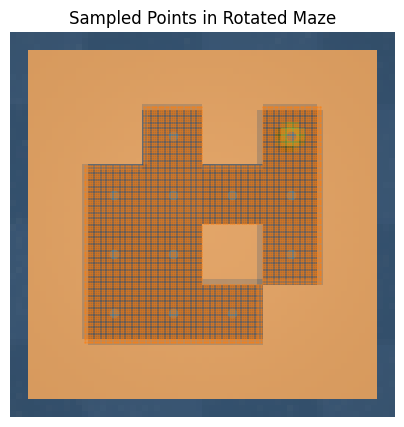

In [213]:
plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
plt.scatter(centers_rotated[:, 0], centers_rotated[:, 1])
plt.scatter(samples_rotated[:, 0], samples_rotated[:, 1], s=1, alpha=0.5)
plt.title("Sampled Points in Rotated Maze")
x_lim = ( -3.25, 3.25 )
y_lim = ( -3.25, 3.25 )
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

Prepare data

In [214]:
frames_th = torch.from_numpy(frames.copy()).permute(0, 3, 1, 2) / 255.0
goal_frame_th = torch.from_numpy(goal_frame.copy()).permute(2, 0, 1).unsqueeze(0) / 255.0

frames_dataset = torch.utils.data.TensorDataset(frames_th)
frames_loader = torch.utils.data.DataLoader(
    frames_dataset, batch_size=1024, shuffle=False
)

Compute value function

In [215]:
with torch.no_grad():
    z_goal_frame_1 = model.visual_encoder(goal_frame_th.to(device))
    _zeros = torch.zeros_like(z_goal_frame_1[:, :2, :])
    z_goal_frame_1 = torch.cat([z_goal_frame_1, _zeros], dim=1)
    
    z_goal_frame_1 = z_goal_frame_1.cpu()

In [216]:
z_frame_in = z_goal_frame_1[:, :16]
M, z_subj, z_bg = pos_decoded = model.compute_mask_and_split(z_frame_in.to(device))
M_numpy = M.cpu().detach().numpy()[0,0]
z_subj_numpy = z_subj.cpu().detach().numpy()[0]
z_bg_numpy = z_bg.cpu().detach().numpy()[0]

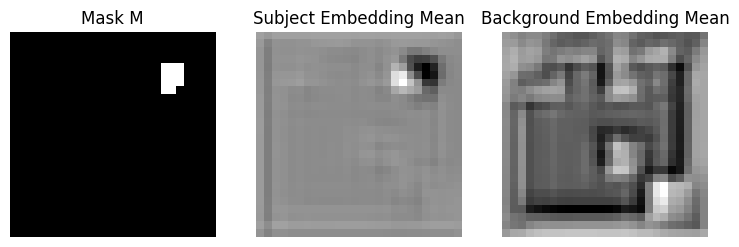

In [217]:
img_m = (M_numpy - M_numpy.min()) / (M_numpy.max() - M_numpy.min())
threshold = 0.9
img_m_binary = (img_m > threshold).astype(np.float32)
img_subj = z_subj_numpy.mean(axis=0)
img_bg = z_bg_numpy.mean(axis=0)
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(img_m_binary, cmap='gray')
axs[0].set_title("Mask M")
axs[0].axis('off')
axs[1].imshow(img_subj, cmap='gray')
axs[1].set_title("Subject Embedding Mean")
axs[1].axis('off')
axs[2].imshow(img_bg, cmap='gray')
axs[2].set_title("Background Embedding Mean")
axs[2].axis('off')
plt.show()  

In [218]:
distances = []
with torch.no_grad():
    for batch in frames_loader:
        batch = batch[0].to(device)
        z_batch = model.visual_encoder(batch)
        _zeros = torch.zeros_like(z_batch[:, :2, :], device=device, dtype=z_batch.dtype)
        z_batch = torch.cat([z_batch, _zeros], dim=1)

        a = model.estimate_position(z_batch[:, :16], threshold=0.9) * 3.25
        a = a.cpu().view(-1, 2)
        # b = z_goal_frame_1
        b = model.estimate_position(z_goal_frame_1[:, :16].to(device), threshold=0.95) * 3.25
        b = b.view(-1, 2).cpu()
        # dist = torch.mean((a - b)**2, dim=(1,2,3))
        dist = torch.mean((a - b)**2, dim=1)
        distances.append(dist.numpy())

distances = np.concatenate(distances)

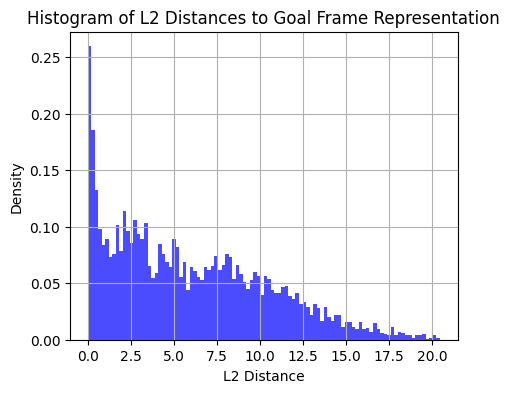

In [219]:
plt.figure(figsize=(5, 4))
plt.hist( 
    distances,
    bins=100, density=True, alpha=0.7, color='blue'
)
plt.title("Histogram of L2 Distances to Goal Frame Representation")
plt.xlabel("L2 Distance")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [220]:
def pit_empirical(x):
    """Probability Integral Transform using empirical CDF."""
    x = np.asarray(x)
    ranks = np.argsort(np.argsort(x)) + 1   # 1..N
    u = ranks / (len(x) + 1)                # avoid 0 and 1
    return u

---

Visualize 

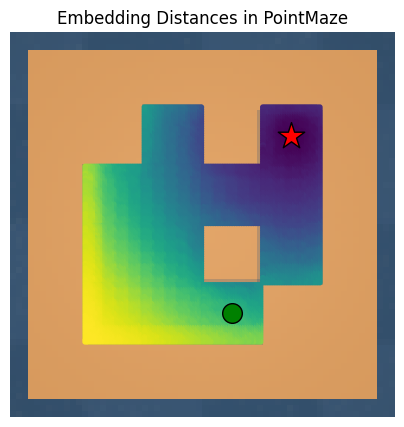

In [221]:
# Apply probability integral transform to distances
distances_pobs = pit_empirical(distances)
# distances_pobs = distances

plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
sc = plt.scatter(
    samples_rotated[:, 0], samples_rotated[:, 1],
    c=distances_pobs, cmap='viridis', s=10
)
# plt.colorbar(sc, label='Cosine Distance to Goal Frame')

# Initial position marker
initial_pos_rotated = rotate90_and_hflip(initial_position.reshape(1, -1))
plt.scatter(
    initial_pos_rotated[0, 0], initial_pos_rotated[0, 1],
    color='green', s=200, edgecolor='black', label='Initial Position'
)
# Goal position marker
goal_pos_rotated = rotate90_and_hflip(goal_position.reshape(1, -1))
plt.scatter(
    goal_pos_rotated[0, 0], goal_pos_rotated[0, 1],
    color='red', s=400, edgecolor='black', label='Goal Position', marker='*'
)

plt.title("Embedding Distances in PointMaze")
plt.xlim(-3.25, 3.25)
plt.ylim(-3.25, 3.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.savefig("pointmaze_embedding_distances.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Planning

In [222]:
with torch.no_grad():
    # Encode initial and goal states with velocity zero
    z_init = model.encode_state(
        # initial_state[:, 2:],
        torch.from_numpy(initial_state.copy()[2:]).unsqueeze(0).float().to(device),
        torch.from_numpy(initial_frame.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    )[0]
    z_goal = model.encode_state(
        torch.from_numpy(goal_state.copy()[2:]).unsqueeze(0).float().to(device),
        torch.from_numpy(goal_frame.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    )[0]

In [223]:
def decompile_model(model):
    # Iterate over all nn.Module attributes of the model
    for name, module in model.named_modules():
        # Check if the module is a MaskHead
        if isinstance(module, torch.nn.Module):
            if hasattr(module, '_orig_mod'):
                print(f"Decompiled {name} to its original module.")
                setattr(model, name, module._orig_mod)

In [224]:
decompile_model(model)

In [243]:
# from planning_tr import GradientPlanner
# from planning_tr.base_planner import CostConfig
# from planning_tr.utils import create_token_mask as create_mask
from planning import GradientPlanner
from planning.base_planner import CostConfig
from planning.utils import create_channel_mask as create_mask

cost_config = CostConfig(
    goal_weight=1.0,
    trajectory_weight=0,
    smoothness_weight=1e-6,
)
mask = create_mask(18, 'visual_only')

In [244]:
# planner = GradientPlanner(
#     model,
#     action_dim=2,
#     action_bounds=(-1,1),
#     initial_lr=1e-1,
#     final_lr=1e-3,
#     num_iterations=50,
#     cost_config=cost_config,
#     channel_mask=mask,
#     noise_std=5,
#     noise_decay=0.8,
#     grad_clip=1.0,
#     action_repeat=1
# )

# result = planner.optimize(
#     z_init,
#     z_goal,
#     horizon=100,
#     verbose=True
# )
# best_actions = result['actions'].cpu().numpy()
# cost_history = result['cost_history']

In [245]:
# from planning import MPPIPlanner

# planner = MPPIPlanner(
#     jepa_model = model,
#     action_dim = 2,
#     action_bounds = (-1.0, 1.0),
#     channel_mask = mask,
#     cost_config = cost_config,
#     # MPPI parameters
#     num_samples = 64,
#     num_iterations = 20,
#     temperature=0.0025,
#     noise_sigma = 2,
#     noise_decay = 0.99,
#     adaptive_temp = True,
#     action_repeat= 1
# )
# result = planner.optimize(
#     z_init,
#     z_goal,
#     horizon=200,
#     verbose=True
# )
# best_actions = result['actions'].cpu().numpy()
# cost_history = result['cost_history']

In [246]:
from planning import CMAESPlanner


planner = CMAESPlanner(
    jepa_model=model,
    action_dim=2,
    action_bounds=(-1.0, 1.0),
    channel_mask=mask,
    cost_config=cost_config,
    # CMA-ES parameters
    population_size=256,
    num_generations=5,
    sigma=1,
    elite_fraction=0.5,
    # Adaptive parameters
    sigma_decay=0.995,
    min_sigma=0.01,
    retain_best=True,
    covariance_type='full',
    action_repeat=2
)
result = planner.optimize(
    z_init,
    z_goal,
    horizon=200,
    verbose=True
)
best_actions = result['actions'].cpu().numpy()
cost_history = result['cost_history']

CMA-ES: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, best=0.0083, mean=0.4037, sigma=0.9752, reduced_h=100]


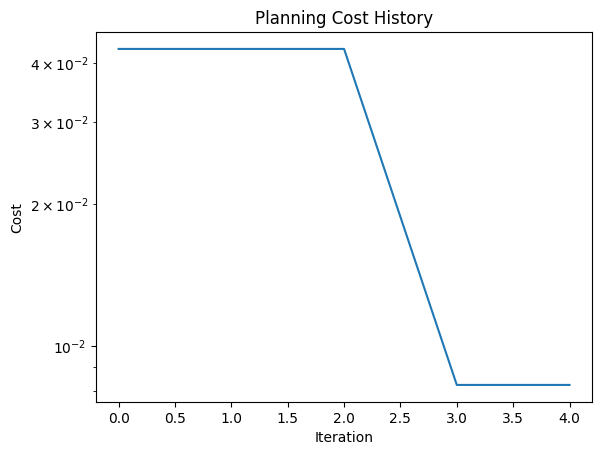

In [247]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Planning Cost History");
plt.yscale('log')

In [248]:
# Simulate the planned actions in the environment
env.reset()
env.set_position(initial_position)
frames = []
frames.append(env.render())
positions = [initial_position.copy()]
for action in best_actions:
    obs_dict, _, _, _, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    positions.append(obs_dict['observation'][:2])
frames = np.array(frames)
positions = np.array(positions)

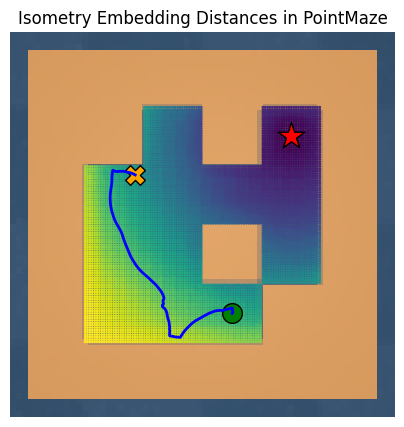

In [249]:
# Apply probability integral transform to distances
distances_pobs = pit_empirical(distances)
# distances_pobs = distances

plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
sc = plt.scatter(
    samples_rotated[:, 0], samples_rotated[:, 1],
    c=distances_pobs, cmap='viridis', s=1
)
# plt.colorbar(sc, label='Cosine Distance to Goal Frame')

# Initial position marker
initial_pos_rotated = rotate90_and_hflip(initial_position.reshape(1, -1))
plt.scatter(
    initial_pos_rotated[0, 0], initial_pos_rotated[0, 1],
    color='green', s=200, edgecolor='black', label='Initial Position'
)
# Goal position marker
goal_pos_rotated = rotate90_and_hflip(goal_position.reshape(1, -1))
plt.scatter(
    goal_pos_rotated[0, 0], goal_pos_rotated[0, 1],
    color='red', s=400, edgecolor='black', label='Goal Position', marker='*'
)

# Planned path
positions_rotated = rotate90_and_hflip(positions)
plt.plot(
    positions_rotated[:, 0], positions_rotated[:, 1],
    color='blue', linewidth=2, label='Planned Path'
)
plt.scatter(
    positions_rotated[-1, 0], positions_rotated[-1, 1],
    color='orange', s=200, edgecolor='black', label='Final Position', marker='X'
)

plt.title("Isometry Embedding Distances in PointMaze")
plt.xlim(-3.25, 3.25)
plt.ylim(-3.25, 3.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

---

In [250]:
z_last = z_init.clone()
state_last = initial_state
goal_xy = goal_state[:2]

env.reset()
env.set_position(state_last[:2])

max_steps = 100
replan = 4
goal_threshold = 1e-4
actions = []
states = [state_last.copy()[:2]]
frames = [env.render()]

progressbar = tqdm(range(max_steps // replan))
for step in progressbar:
    
    # --- PLAN ---
    result = planner.optimize(
        z_last,
        z_goal,
        horizon=200,
        verbose=False
    )
    planned_actions = result['actions'][:replan].cpu().numpy()
    actions.append(planned_actions)

    # --- EXECUTE IN REAL ENV ---
    for action in planned_actions:
        obs_dict, _, _, _, _ = env.step(action)
        state = obs_dict['observation']
        pos = state[:2]                    # (x, y) real coordinates
        frame = env.render()

        states.append(pos.copy())
        frames.append(frame)

        # update for next iteration
        state_last = state

        # -----------------------------------------------------
        # 🔥 REAL GOAL CHECK USING (x,y)
        # -----------------------------------------------------
        dist_xy = np.linalg.norm(pos - goal_xy)
        if dist_xy < goal_threshold:
            print(f"Goal reached at step {len(states)}  dist={dist_xy:.4f}")
            break
        # -----------------------------------------------------

    # Stop outer loop if goal reached
    if dist_xy < goal_threshold:
        break
    progressbar.set_description(f"Distance to Goal: {dist_xy:.4f}")

    # --- RE-ENCODE LATENT FOR NEXT MPC REPLAN ---
    with torch.no_grad():
        st = torch.from_numpy(state_last[2:].copy()).unsqueeze(0).float().to(device)
        fr = torch.from_numpy(frame.copy()).permute(2,0,1).unsqueeze(0).float().to(device)
        z_last = model.encode_state(st, fr).squeeze(0)

positions = np.array(states)[:, :2]

Distance to Goal: 3.4414: 100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


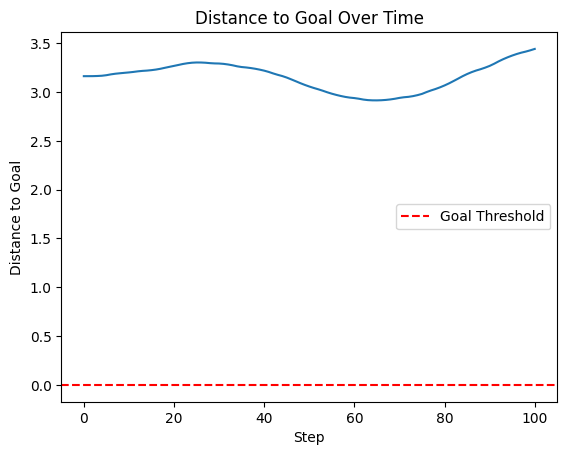

In [251]:
plt.plot(((positions-goal_position)**2).sum(axis=1)**0.5)
# add threshold line
plt.axhline(goal_threshold, color='red', linestyle='--', label='Goal Threshold')
plt.xlabel("Step")
plt.ylabel("Distance to Goal")
plt.title("Distance to Goal Over Time")
plt.legend()
plt.show()

---

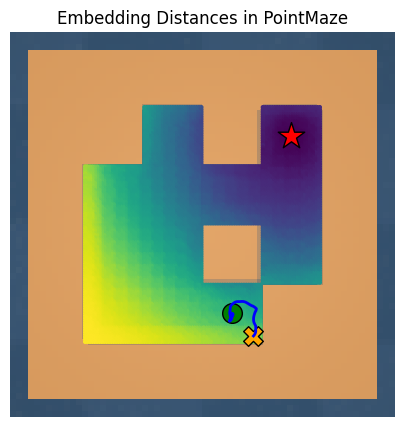

In [252]:
# Apply probability integral transform to distances
distances_pobs = pit_empirical(distances)

plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
sc = plt.scatter(
    samples_rotated[:, 0], samples_rotated[:, 1],
    c=distances_pobs, cmap='viridis', s=5
)
# plt.colorbar(sc, label='Cosine Distance to Goal Frame')

# Initial position marker
initial_pos_rotated = rotate90_and_hflip(initial_position.reshape(1, -1))
plt.scatter(
    initial_pos_rotated[0, 0], initial_pos_rotated[0, 1],
    color='green', s=200, edgecolor='black', label='Initial Position'
)
# Goal position marker
goal_pos_rotated = rotate90_and_hflip(goal_position.reshape(1, -1))
plt.scatter(
    goal_pos_rotated[0, 0], goal_pos_rotated[0, 1],
    color='red', s=400, edgecolor='black', label='Goal Position', marker='*'
)

# Planned path
positions_rotated = rotate90_and_hflip(positions)
plt.plot(
    positions_rotated[:, 0], positions_rotated[:, 1],
    color='blue', linewidth=2, label='Planned Path'
)
plt.scatter(
    positions_rotated[-1, 0], positions_rotated[-1, 1],
    color='orange', s=200, edgecolor='black', label='Final Position', marker='X'
)

plt.title("Embedding Distances in PointMaze")
plt.xlim(-3.25, 3.25)
plt.ylim(-3.25, 3.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

In [203]:
# Save video with imageio
video_path = "planned_path.mp4"
imageio.mimwrite(video_path, frames, fps=20)
# Display video in notebook
Video(video_path, embed=True, width=400)